## Jigsaw puzzle


According to the [GWHD paper](https://arxiv.org/pdf/2005.02162.pdf) the images were split into 1024x1024 squared patches. In this notebook, I will solve this jigsaw puzzle to get original full-size image. It will help you have more data in (crop) augmentation like this: 

![Imgur](https://i.imgur.com/PPeOZZu.png)

Note: *This notebook is inspired by [Peter's notebook](http://www.kaggle.com/pestipeti/jigsaw-puzzle-solved). You will probably notice that the first few lines between the two notebooks are the same. However, my code is not like his. I use another algorithm to calculate the difference between two edges of two images and use another strategy. My algorithm can handle all his cases which are not possible. (Sorry for my bad English ^^)*

![Imgur](https://i.imgur.com/k2TSrzw.jpg)

## How it works
1. For each source, the original full-size image is divided into a patch-grid: (2, 3), (2, 2), (1,2).. etc
2. From all of the images, it saves the left, right, top, and bottom edges. ( [1024,1,3] array per edges)
3. I define a distance_function to calculate the difference between 2 edges
4. I calculate the distance between all pairs of left-right (top-bottom) edges and save in LR_distance (TB_distance) matrix 

5. I loop through each image: 
    
    5.1 Set this image as top-left image (0,0) in patch grids. 
    
    5.2 Find the best image one by one based on the distance with previous images.
    
    5.3 I will compare the total distance with a threshold and decide whether to keep it or not. All threshold values I have chosen very carefully. You can safely use them

## TODO: 
Merging the split boxes

## OK, Let's go 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
from random import randint
from IPython.display import clear_output
import ast

In [2]:
## Init constant
DATA_DIR = '/kaggle/input/global-wheat-detection'
IMG_DIR = f"{DATA_DIR}/train"
TARGETS = ['arvalis_1', 'arvalis_2', 'arvalis_3', 'inrae_1', 'usask_1', 'rres_1', 'ethz_1']
N_PATCH = [(2, 3), (2, 2), (2, 2), (2, 2), (1, 2), (2, 3), (1, 2)]
BOX_COLOR = [0,0,255]

### Image utils function

In [3]:
def plot_img(img, size=(7,7), is_rgb=False, title=""):
    if isinstance(img, str):
        img = load_img(img)
    plt.figure(figsize=size)
    if is_rgb:
        plt.imshow(img)
    else:
        plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=5, size=7, is_rgb=False, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if isinstance(img, str):
            img = load_img(img, size=300)
        fig.add_subplot(rows, cols, i+1)
        if is_rgb:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def visualize_bbox(img, boxes, thickness=3, color=BOX_COLOR):
    img_copy = img.copy()
    for box in boxes:
        img_copy = cv2.rectangle(
            img_copy,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness)
    return img_copy

def load_img(img_id):
    cv2.imread(f"{IMG_DIR}/{img_id}.jpg")

In [4]:

df = pd.read_csv(f"{DATA_DIR}/train.csv")
df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(np.stack(df['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)
df['x2'] = df['x1'] + df['w']
df['y2'] = df['y1'] + df['h']
df.head()

,image_id,width,height,bbox,source,x1,y1,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


## Get left, right, top, bottom edges each image 

Note: Change TAR_ID for each soure

In [5]:
TAR_ID = 0
img_ids = df[df["source"] == TARGETS[TAR_ID]]["image_id"].unique()
IMG_N = len(img_ids)
print(IMG_N)

l_edges = []
r_edges = []
t_edges = []
b_edges = []

for i, img_id in enumerate(img_ids):
    img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
    ## normalize values by dividing max values
    l_edges.append(img[:,:1,:] / img[:,:1,:].max())
    r_edges.append(img[:,-1:,:] / img[:,-1:,:].max())
    t_edges.append(img[:1,:,:] / img[:1,:,:].max())
    b_edges.append(img[-1:,:,:] / img[-1:,:,:].max())
    
l_edges = np.squeeze(np.array(l_edges))
r_edges = np.squeeze(np.array(r_edges))
t_edges = np.squeeze(np.array(t_edges))
b_edges = np.squeeze(np.array(b_edges))

1055


## Compute left-right distance, top-bottom distance matrix

LR_distance[i,j]: distance between I image's left edge and J image's right edge

TB_distance[i,j]: distance between I image's top edge and J image's bottom edge

In [6]:
def distance(edge1, edge2):
    d1 = np.abs(edge1 - edge2).mean()
    d2 = np.abs(edge1[1:,:] - edge2[:-1,:]).mean()
    d3 = np.abs(edge2[1:,:] - edge1[:-1,:]).mean()
    total_distance = d1+d2+d3
    return total_distance


LR_distance = np.zeros((IMG_N, IMG_N)) + 1e3
TB_distance = np.zeros((IMG_N, IMG_N)) + 1e3

for i, left in enumerate(l_edges):
    for j, right in enumerate(r_edges):
        if i == j:
            continue
        LR_distance[i,j] = distance(left, right)
print(LR_distance.shape)


for i, top in enumerate(t_edges):
    for j, bottom in enumerate(b_edges):
        if i == j:
            continue
        TB_distance[i,j] = distance(top, bottom)
print(TB_distance.shape)

(1055, 1055)
(1055, 1055)


# Search best matches 

In [7]:
def get_best_bottom_img(top_id, TB_distance):
    index = np.argmin(TB_distance[:, top_id])
    distance = TB_distance[index, top_id]
    return index, distance

def get_best_right_img(left_id, LR_distance):
    index = np.argmin(LR_distance[:, left_id])
    distance = LR_distance[index, left_id]
    return index, distance

def get_best_right_bottom_img(top_id, left_id, TB_distance, LR_distance):
    index = np.argmin(TB_distance[:, top_id] + LR_distance[:, left_id])
    distance = (TB_distance[index, top_id] + LR_distance[index, left_id])/2
    return index, distance

def index_grid_to_info_grid(patch_grid, img_ids):
    h_grid, w_grid = patch_grid.shape
    PATCH_INFO_GRID = np.zeros(patch_grid.shape).astype(np.object)
    for row in range(h_grid):
        for col in range(w_grid):
            index = patch_grid[row, col]
            PATCH_INFO_GRID[row, col] = {
                "index": index,
                "img_id": img_ids[index]
            }
    return PATCH_INFO_GRID


## Convert index-grid to info-grid
def combine_result(patch_grid, df):
    h, w = patch_grid.shape
    total_img = np.zeros((h*1024, w*1024, 3))
    all_boxes = []
    patch_img_ids = []
    
    for r in range(h):
        for c in range(w):
            img_id = patch_grid[r, c]["img_id"]
            patch_img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
            
            xrange = [c*1024, (c+1)*1024]
            yrange = [r*1024, (r+1)*1024]
            total_img[
                yrange[0] : yrange[1],
                xrange[0] : xrange[1], :
            ] = patch_img
            
            boxes = df[df["image_id"] == img_id][["x1", 'y1', 'x2', 'y2']]
            boxes["x1"] += xrange[0]
            boxes["x2"] += xrange[0]
            boxes["y1"] += yrange[0]
            boxes["y2"] += yrange[0]
            all_boxes.append(boxes)
            patch_img_ids.append(img_id)
    all_boxes = pd.concat(all_boxes)
    total_img = total_img.astype(np.uint8)
    return total_img, all_boxes, patch_img_ids

## Main stratery

In [8]:
print(TAR_ID)
THRESHOLDS = [0.25, 0.33, 0.25, 0.25, 0.2, 0.1, 0.25]
threshold = THRESHOLDS[TAR_ID]
ALL_PATCH_GRIDS = []

for i, img_id in enumerate(img_ids):
    PATCH_GRID = np.zeros(N_PATCH[TAR_ID]).astype(np.object)
    h_grid, w_grid = PATCH_GRID.shape 
    PATCH_GRID[0,0] = i
    all_distance = []
    
    for row in range(h_grid):
        for col in range(w_grid):
            if col == 0 and row == 0:
                continue
            if col == 0:
                top_id = int(PATCH_GRID[row-1, col])
                PATCH_GRID[row, col], distance = get_best_bottom_img(top_id, TB_distance)
            if row == 0:
                left_id = int(PATCH_GRID[row, col-1])
                PATCH_GRID[row, col], distance = get_best_right_img(left_id, LR_distance)
            if row*col > 0:
                top_id = PATCH_GRID[row-1,col]
                left_id = PATCH_GRID[row, col-1]
                PATCH_GRID[row, col], distance = get_best_right_bottom_img(
                    top_id, left_id,
                    TB_distance, LR_distance
                )
            all_distance.append(distance)

    avg_distance = np.mean(all_distance)
    if avg_distance < threshold:
        ALL_PATCH_GRIDS.append(PATCH_GRID)
        
print(len(ALL_PATCH_GRIDS))

0
106


## Save new data

Remove the comment code if you want to save data

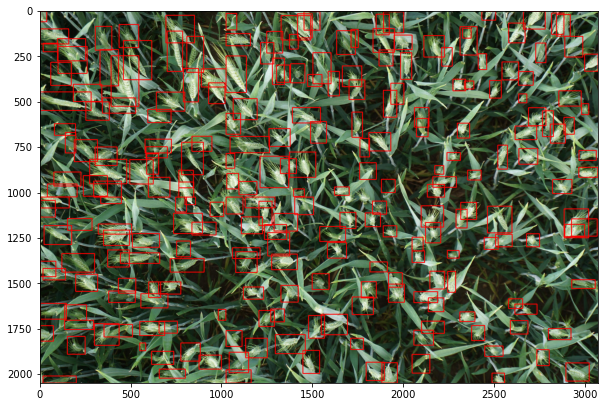

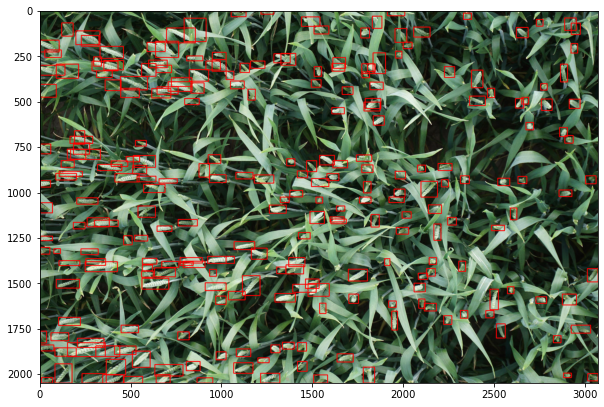

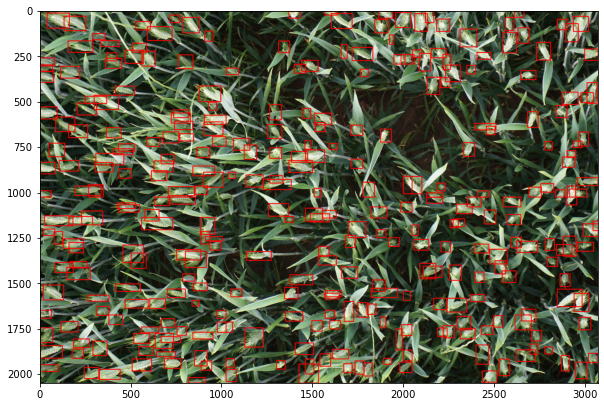

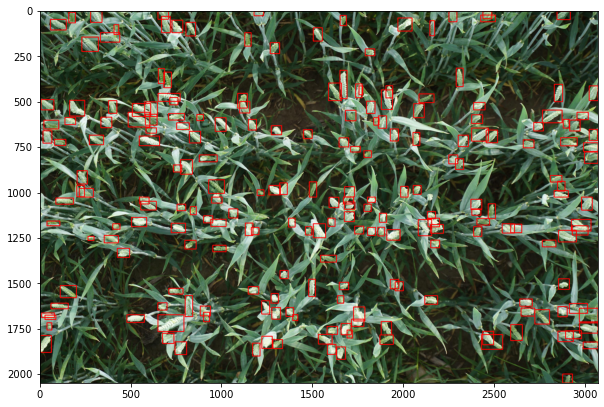

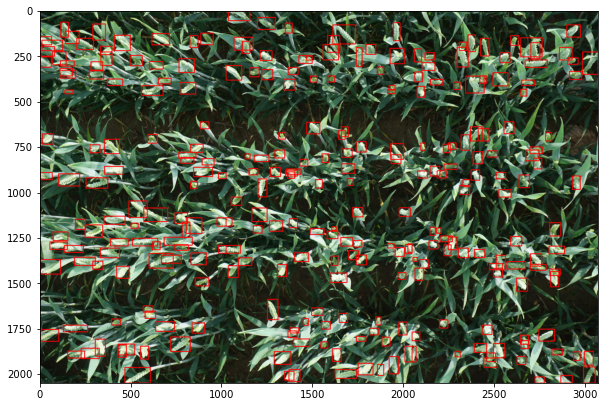

SAVE NEW DATA IN: origin_arvalis_1.csv


In [9]:
all_new_data = []
source = TARGETS[TAR_ID]
new_img_dir = "origin_img" 
# os.makedirs(new_img_dir, exist_ok=True)

for i, patch_grid in enumerate(ALL_PATCH_GRIDS):
    patch_grid = index_grid_to_info_grid(patch_grid, img_ids)
    total_img, boxes, patch_img_ids = combine_result(patch_grid, df)
    new_img_ids = source + '_' + "_".join(patch_img_ids)
    boxes["image_id"] = new_img_ids
    all_new_data.append(boxes)
#     cv2.imwrite(f"{new_img_dir}/{new_img_ids}.jpg", total_img)
    
    if i < 5:
        total_img = visualize_bbox(total_img, boxes.values)
        plot_img(total_img, size=(10,10))

all_new_data = pd.concat(all_new_data)
csv_path = f"origin_{source}.csv"
print(f"SAVE NEW DATA IN: {csv_path}")

# all_new_data.to_csv(csv_path)

## If you like it, upvote me ^^